In [1]:
#import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [4]:
#get the classes from our dataset
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#image exploration
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 2 0 1 1 1 1 0]


In [6]:
#plot image samples with class labels
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[1]])
        plt.axis("off")
        
        

In [7]:
#split dataset into train test splits
#80% training, 20% test(10% validation and 10% test)

In [8]:
#create a train dataset
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [9]:
train_ds=dataset.take(54)
#confirm the train ds
len(train_ds)

54

In [10]:
#create test dataset
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
#split the test dataset into 10% validation and 10% test
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [12]:
#validation dataset
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
#test datset
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
#function to get the dataset partition
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return(train_ds, val_ds, test_ds)

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
#caching and prefetching to optimize the dataset for training performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [20]:
#ds preprocessing
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #resize our image to 256
    layers.experimental.preprocessing.Rescaling(1.0/255) ##our dataset is an RGB
])

In [21]:
#perfom data augmentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #flip images
    layers.experimental.preprocessing.RandomRotation(0.2) #applying rotation to the image dataset
])

In [22]:
#build a CNN model
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="softmax"),
    
])

model.build(input_shape=input_shape)
    

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
#define the optimizer, loss function and metrix
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)
    

In [25]:
#training our model with epochs and record histry of every epoch to follow up on the model perfomance
history= model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    
)


Epoch 1/50
54/54 [==============================] - 137s 2s/step - loss: 1.2671 - accuracy: 0.4861 - val_loss: 0.8406 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 118s 2s/step - loss: 0.8141 - accuracy: 0.6372 - val_loss: 0.6788 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 112s 2s/step - loss: 0.6964 - accuracy: 0.6794 - val_loss: 0.5298 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 115s 2s/step - loss: 0.4968 - accuracy: 0.7992 - val_loss: 0.6321 - val_accuracy: 0.8177
Epoch 5/50
54/54 [==============================] - 129s 2s/step - loss: 0.3716 - accuracy: 0.8553 - val_loss: 0.3327 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 123s 2s/step - loss: 0.2802 - accuracy: 0.8883 - val_loss: 0.2743 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 134s 2s/step - loss: 0.2592 - accuracy: 0.8964 - val_loss: 0.2428 - val_accuracy: 0.9115
Epoch 8/50
54

In [26]:
#run the model on our test dataset
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 354ms/step - loss: 0.1319 - accuracy: 0.9609


In [27]:
#print the loss and accuracy
scores

[0.1318766176700592, 0.9609375]

In [38]:
#create a plot indicating the loss, accuracy, and validation data acc and loss as well.
acc =history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

#plot showing training and validation loss

#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS),val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

Text(0.5, 1.0, 'Training and Validation loss')

first image to predict
first image's actual label Potato___Late_blight
1/1 [==============================] - 1s 560ms/step
predicted label: Potato___Late_blight


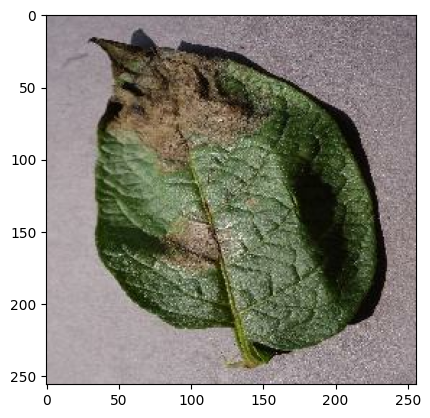

In [70]:
#make a prediction from our model
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])

 #get a prediction
    import numpy as np
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    

In [85]:
#function for the prediction and confidence of prediction
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch


    predictions = model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence
    


1/1 [==============================] - 0s 65ms/step


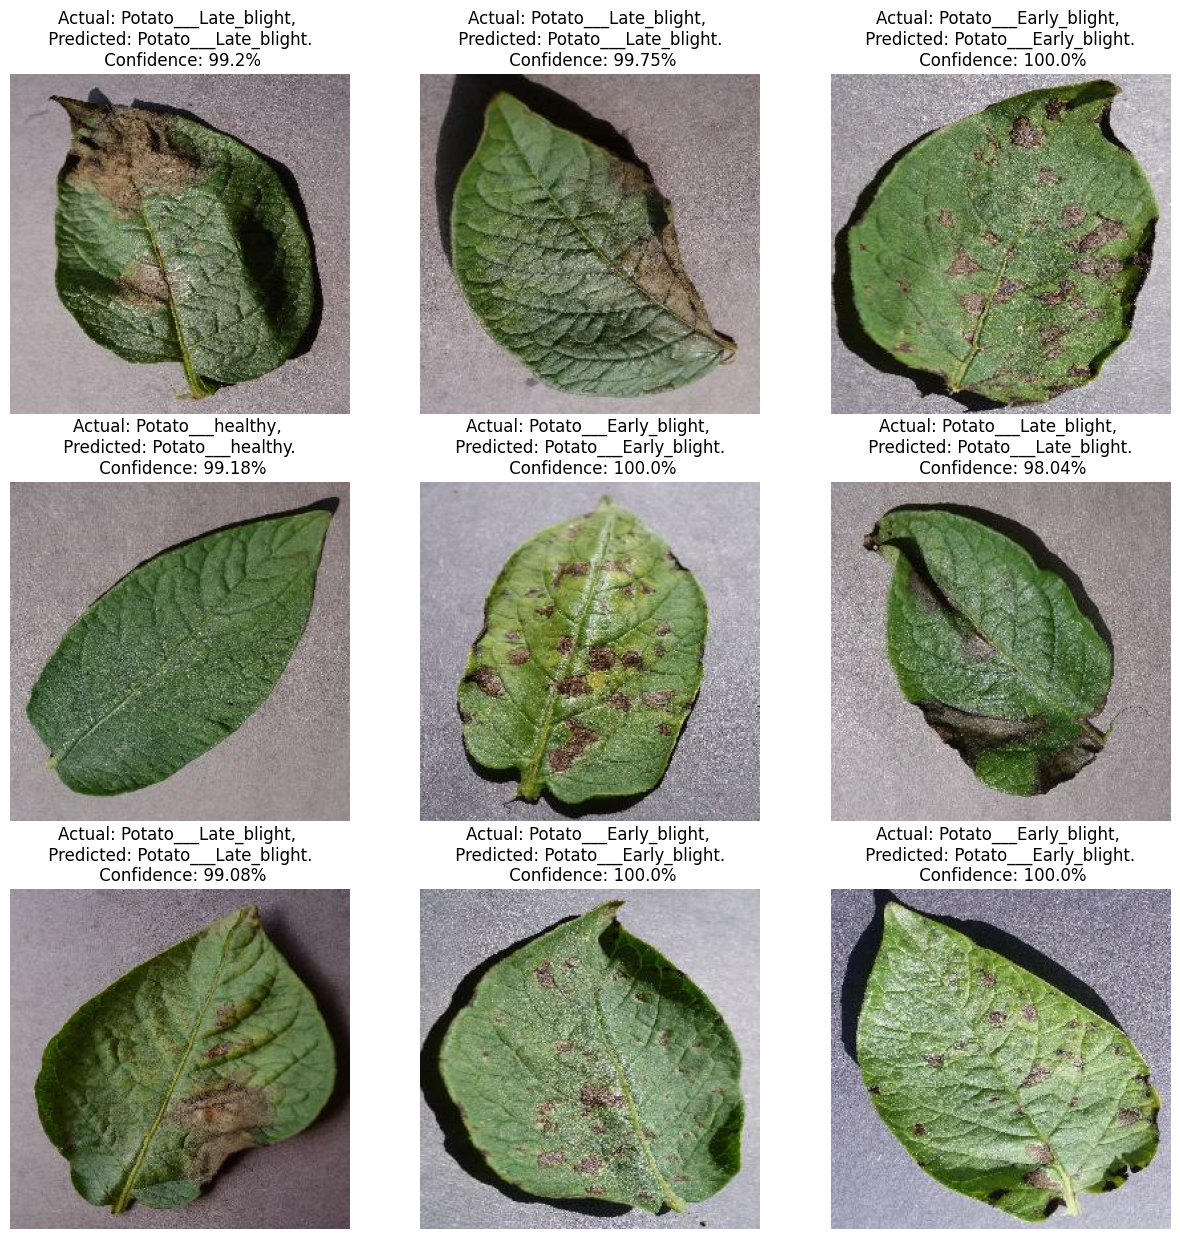

In [90]:
#run the prediction onto the entire batch but just using 9 images, using the function created
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

#from the results our model is perfoming well.
        
        

In [91]:
#save model to disk
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
